In [2]:
import json
from ds_util import head

In [3]:
yelp_dataset_path = '/nvme0n1p2/yelp_dataset/'
yelp_photo_path = '/nvme0n1p2/yelp_photos/'

# 交互数据

## Step1：从 review 数据集中提取所有用户，并统计每个用户的评论数量

In [7]:
# 加载 user_id 为集合
user_ids = set()
with open(yelp_dataset_path + 'yelp_academic_dataset_user.json', 'r', encoding='utf-8') as f_users:
    for line in f_users:
        user_data = json.loads(line)
        user_ids.add(user_data['user_id'])

# 统计每个 user_id 的实际 reviews 数量
user_review_count = {}

with open(yelp_dataset_path + 'yelp_academic_dataset_review.json', 'r', encoding='utf-8') as review_file:
    for line in review_file:
        review_data = json.loads(line)
        user_id = review_data['user_id']
        if user_id in user_ids:
            if user_id in user_review_count:
                user_review_count[user_id] += 1
            else:
                user_review_count[user_id] = 1

# 保存为本地文件
with open('yelp_out/user_review_count.txt', 'w', encoding='utf-8') as output_file:
    for user_id, count in user_review_count.items():
        output_file.write(f"{user_id} {count}\n")
    
    print("generate complete")

generate complete


In [18]:
head('yelp_out/user_review_count.txt')

mh_-eMZ6K5RLWhZyISBhwA 28



## Step2：筛选出交互次数（评论数）大于等于 10 次的用户

In [9]:
items = {}
with open('yelp_out/user_review_count.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # count_data -> [user_id, review_count]
        count_data = line.strip().split(' ')
        if int(count_data[1]) >= 10:
            items[count_data[0]] = count_data[1]
        if int(count_data[1]) < 1:
            print(f'user {count_data[0]} has 0 review!')

# 保存为本地文件
with open('yelp_out/core_users.txt', 'w', encoding='utf-8') as output_file:
    for user_id, count in items.items():
        output_file.write(f"{user_id} {count}\n")
    
    print("generate complete")

generate complete


In [19]:
head('yelp_out/core_users.txt')

mh_-eMZ6K5RLWhZyISBhwA 28



## Step3：从 review 数据集中提取所有项目商家，并统计每个商家的评论数量

In [23]:
# 加载 business_id 为集合
business_ids = set()
with open(yelp_dataset_path + 'yelp_academic_dataset_business.json', 'r', encoding='utf-8') as f_item:
    for line in f_item:
        item_data = json.loads(line)
        business_ids.add(item_data['business_id'])

# 统计每个 business_id 的实际 reviews 数量
item_review_count = {}

with open(yelp_dataset_path + 'yelp_academic_dataset_review.json', 'r', encoding='utf-8') as review_file:
    for line in review_file:
        review_data = json.loads(line)
        business_id = review_data['business_id']
        if business_id in business_ids:
            if business_id in item_review_count:
                item_review_count[business_id] += 1
            else:
                item_review_count[business_id] = 1

# 保存为本地文件
with open('yelp_out/item_review_count.txt', 'w', encoding='utf-8') as output_file:
    for business_id, count in item_review_count.items():
        output_file.write(f"{business_id} {count}\n")
    
    print("generate complete")

generate complete


In [27]:
head('yelp_out/item_review_count.txt')

XQfwVwDr-v0ZS3_CbbE5Xw 175



## Step4：筛选出交互次数大于等于 10 次且存在 photos 数据的商家

理论上说，10-core settings 只需要交互次数限制就可以了。但本文由于需要图片模态数据，而实际处理过程中发现如果不添加“有图片”的限制条件，生成的数据集中，将有约 67% 的 business 没有对应的 photos 数据。

In [15]:
items = {}
business_with_photos = set()

try:
    with open(yelp_photo_path + 'photos.json', 'r') as photo_list:
        for line in photo_list:
            data = json.loads(line)
            business_id = data['business_id']
            business_with_photos.add(business_id)

    with open('yelp_out/item_review_count.txt', 'r', encoding='utf-8') as file:
        for line in file:
            # count_data -> [business_id, review_count]
            count_data = line.strip().split(' ')
            if int(count_data[1]) >= 10 and count_data[0] in business_with_photos:
                items[count_data[0]] = count_data[1]
            if int(count_data[1]) < 1:
                print(f'business {count_data[0]} has 0 review!')

    # 保存为本地文件
    with open('yelp_out/re_core_items.txt', 'w', encoding='utf-8') as output_file:
        for business_id, count in items.items():
            output_file.write(f"{business_id} {count}\n")
        
        print("generate complete")

except Exception as e:
    print(f'errors: {e}')

generate complete


In [30]:
head('yelp_out/core_items.txt')

XQfwVwDr-v0ZS3_CbbE5Xw 175



## Step5：交叉过滤-从 review 数据集中提取出 10-core 交互记录

注意，yelp 数据集自带换行符

In [46]:
with open(yelp_dataset_path + 'yelp_academic_dataset_review.json', 'r', encoding='utf-8') as review_file:
    for line in review_file:
        if '\n' in line: 
            print('yes')
            break

yes


此外，由于存在一个用户对同一商家的多条评论记录，因此构造过滤 review 数据集时，需考虑以下几方面：
1. 用户和项目都是核心用户/项目
2. (user_id ,business_id) 不重复
3. 针对重复的情况，取评分最高项

In [16]:
core_users = set()
items = set()
# 保证一个用户对一个项目只有一条交互记录
user_item_pairs = {}

with open('yelp_out/core_users.txt', 'r', encoding='utf-8') as file:
    for line in file:
        user_id = line.strip().split(' ')[0]
        core_users.add(user_id)

with open('yelp_out/re_core_items.txt', 'r', encoding='utf-8') as file:
    for line in file:
        business_id = line.strip().split(' ')[0]
        items.add(business_id)

filter_reviews = []  # -> [user_id, business_id, stars, review_id]
index = 0
with open(yelp_dataset_path + 'yelp_academic_dataset_review.json', 'r', encoding='utf-8') as review_file:
    for line in review_file:
        review_data = json.loads(line)
        user_id = review_data['user_id']
        business_id = review_data['business_id']

        if user_id in core_users and business_id in items:
            if (user_id, business_id) not in user_item_pairs:
                # 用哈希表同时记录评分和索引，以便后续操作
                user_item_pairs[(user_id, business_id)] = [review_data['stars'], index]
                # filter_reviews.append([user_id, business_id, review_data['stars'], review_data['review_id']])
                filter_reviews.append([user_id, business_id, review_data['stars']])
                index += 1
            else:
                if review_data['stars'] > user_item_pairs[(user_id, business_id)][0]:
                    pair_index = user_item_pairs[(user_id, business_id)][1]
                    # 更新数据
                    # filter_reviews[pair_index] = [user_id, business_id, review_data['stars'], review_data['review_id']]
                    filter_reviews[pair_index] = [user_id, business_id, review_data['stars']]

# 持久化过滤后的评论数据集
with open('yelp_out/re_yelp_interactions.txt', 'w', encoding='utf-8') as out_file:
    for record in filter_reviews:
        out_file.write(' '.join(map(str, record)) + '\n')
    print('Filter reviews done')


Filter reviews done


In [18]:
head('yelp_out/re_yelp_interactions.txt', 2)

bcjbaE6dDog4jkNY91ncLQ e4Vwtrqf-wpJfwesgvdgxQ 4.0

smOvOajNG0lS4Pq7d8g4JQ RZtGWDLCAtuipwaZ-UfjmQ 4.0



## Step6：划分数据集

参考 [SELFRec issue 54](https://github.com/Coder-Yu/SELFRec/issues/54)，领域内在得到最终结果时，似乎会把训练集和验证集合并，所以这里直接按 7:3 划分训练集跟测试集好了。

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('yelp_out/re_yelp_interactions.txt', delimiter=' ', header=None)

# 检查重复行
print(f"原始数据重复行数: {data.duplicated().sum()}")

# 划分训练集和测试集，比例为7:3
train_data, test_data = train_test_split(data, test_size=0.3, random_state=114514)

train_data.to_csv('yelp_ds_re/train_data.txt', index=False, header=False, sep=' ')
test_data.to_csv('yelp_ds_re/test_data.txt', index=False, header=False, sep=' ')

# 查看划分后的数据集大小
print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

# 检查是否有重复项
print(f"训练数据重复行数: {train_data.duplicated().sum()}")
print(f"测试数据重复行数: {test_data.duplicated().sum()}")
duplicates_in_train = train_data.merge(test_data, how='inner')
print(f'训练集和测试集中的重复行:\n{duplicates_in_train}')


原始数据重复行数: 0
训练集大小: 1429167
测试集大小: 612501
训练数据重复行数: 0
测试数据重复行数: 0
训练集和测试集中的重复行:
Empty DataFrame
Columns: [0, 1, 2]
Index: []


# 图像数据

1. 根据生成的 interactions 数据，对第二列建立集合，即数据集中所有 business_id
2. 将 business_id 代入 `photos/` 检索出所有 photo_id 并保存文件

## 图像记录数据展示

In [6]:
head(yelp_photo_path + 'photos.json', jsonf=True)

{
  "photo_id": "zsvj7vloL4L5jhYyPIuVwg",
  "business_id": "Nk-SJhPlDBkAZvfsADtccA",
  "caption": "Nice rock artwork everywhere and craploads of taps.",
  "label": "inside"
}


## 商家-图片映射记录

从最终的**交互数据集**中，提取出商家-图片(一对多)的映射关系。

In [20]:

photo_ids = set()
items = set()
item2photos = {}

try:
    with open('yelp_out/re_yelp_interactions.txt', 'r') as interact_file:
        for line in interact_file:
            items.add(line.split(' ')[1])
            item2photos[line.split(' ')[1]] = []
    
    # item: photo_id1, photo_id2, ...
    with open('yelp_out/item2photos.txt', 'w', encoding='utf-8') as out_file:
        with open(yelp_photo_path + 'photos.json', 'r', encoding='utf-8') as photos:
            for line in photos:
                json_data = json.loads(line)
                photo_id = json_data['photo_id']
                business_id = json_data['business_id']

                # 存在 photo_id 重复的情况
                if photo_id not in photo_ids and business_id in items:
                    item2photos[business_id].append(photo_id)
                else:
                    continue
        
        for item in item2photos:
            out_file.write(item + ' ' + ' '.join(item2photos[item]) + '\n')
        print('generate complete')
except Exception as e:
    print(f'error: {e}')

generate complete


In [21]:
with open('yelp_out/item2photos.txt', 'r') as f:
    no_photos_item = 0
    total_item = 0

    for line in f:
        total_item += 1
        parts = line.split(' ')
        business_id = parts[0]
        photo_ids = parts[1:]

        if photo_ids[0] == '\n':
            no_photos_item += 1

    print(f'{no_photos_item} business without any photo')
    print(f'occupy {no_photos_item/total_item*100}%')

0 business without any photo
occupy 0.0%


## 图像本体

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

-rCqVHSxxfNSCBLvFE_U6Q


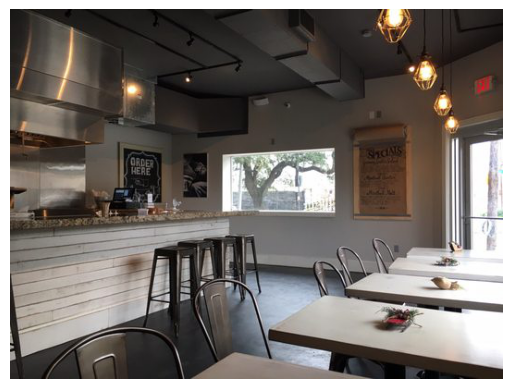

Image size: 533x400 pixels
xf4Te_a-Z75q4qN4swVq_Q


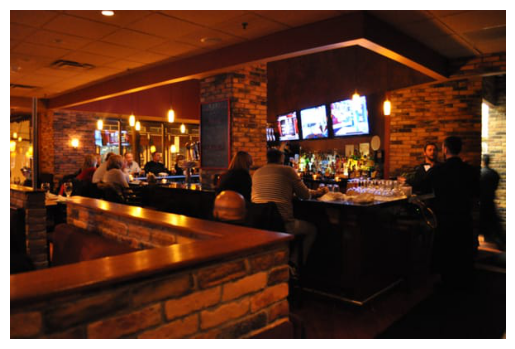

Image size: 600x398 pixels
EtY7zYFX9tmzQicigar8jg


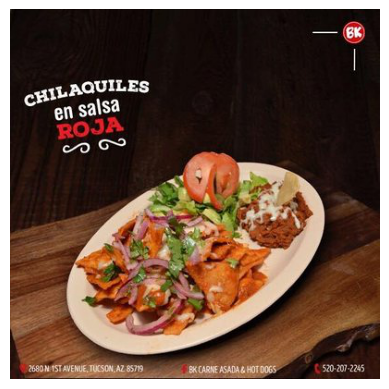

Image size: 400x400 pixels
NBaCljEHjCIpYl1LcQhqHA


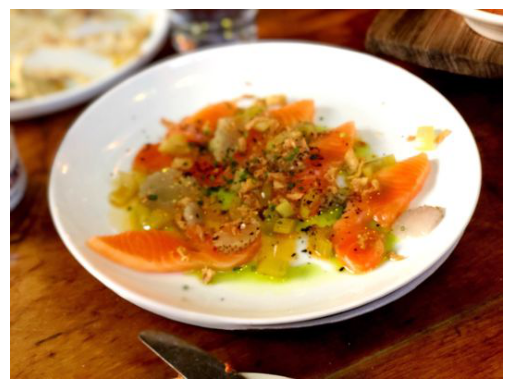

Image size: 533x400 pixels


In [6]:
# 打开图像文件
img_name = []
with open('yelp_out/item2photos.txt', 'r') as f:
    for index, line in enumerate(f):
        img_name.append(line.split(' ')[1])
        if index == 3: break

for idx in range(4):
    print(img_name[idx])
    img = Image.open(f'{yelp_photo_path}photos/{img_name[idx]}.jpg')  # 替换为你的图片路径
    width, height = img.size
    # 显示图像
    plt.imshow(img)
    plt.axis("off")  # 不显示坐标轴
    plt.show()
    print(f"Image size: {width}x{height} pixels")

可以看见，图像大小并不统一

## 使用 [CLIP-ViT](https://huggingface.co/openai/clip-vit-base-patch32) 对图像进行编码

- [tutorial 1](https://medium.com/@highsunday0630/image-embedding-1-clip%E6%A8%A1%E5%9E%8B%E6%8F%90%E5%8F%96-image-embedding-%E4%B8%A6%E4%BB%A5-tensorboard-%E8%A6%96%E8%A6%BA%E5%8C%96%E6%95%88%E6%9E%9C-dc281370d7d8)
- [tutorial 2](https://blog.csdn.net/qq_37756660/article/details/135979873)

In [2]:
from transformers import CLIPProcessor, CLIPModel
from safetensors.torch import save_file
from PIL import Image
from safetensors import safe_open
import os
import tqdm
import logging
import torch
from torch.nn.parallel import DataParallel

In [3]:
model_path = "/home/yzh/code/SELFRec/model/clip-vit-base-patch32"
# 图片存储路径
directory = '/nvme0n1p2/yelp_photos/photos'

In [4]:
photos = set()  # 所有需要处理的图片
with open('yelp_out/item2photos.txt', 'r', encoding='utf-8') as file:
    for line in file:
        for photo_id in line.strip().split(' ')[1:]:
            photos.add(photo_id)

yelp 数据集中的 photo 数据存在脏数据(无法识别、损坏)

> 我是没想到公开数据集连这个都不处理好😅

那就写个日志看看有多少脏数据吧

In [5]:
import logging
photo_logger = logging.getLogger('error_photo')
photo_logger.setLevel(logging.INFO)
sh = logging.FileHandler('../log/error_photo.log')
sh.setLevel(logging.WARNING)
formatter = logging.Formatter('%(name)s - %(message)s')
sh.setFormatter(formatter)
photo_logger.addHandler(sh)

In [ ]:
# 检查是否有多个GPU可用
device_ids = list(range(torch.cuda.device_count()))

if len(device_ids) < 2:
    # 加速了个🥚, GPU 1 动都不动
    print("至少需要两个GPU才能进行多GPU加速")
else:
    # 加载模型
    # model = CLIPModel.from_pretrained(model_path).to(f'cuda:{device_ids[0]}')
    model = CLIPModel.from_pretrained(model_path).to('cuda')
    model = DataParallel(model, device_ids=device_ids)
    processor = CLIPProcessor.from_pretrained(model_path)

    # 定义批量大小
    batch_size = 64

    # 初始化计数器
    photo_num = 0
    processed_num = 0
    error_num = 0
    photo_embs = {}

    # 读取目录中的图片
    with os.scandir(directory) as entries:
        images = []  # 待处理图片列表
        photo_ids = []  # 图片ID列表

        # 遍历目录中的所有文件
        for entry in tqdm.tqdm(entries):
            photo_id = entry.name.replace('.jpg', '')
            if photo_id not in photos:
                continue
            photo_num += 1
            try:
                images.append(Image.open(entry.path))
                photo_ids.append(photo_id)
            except Exception as e:
                photo_logger.warning(f'{entry.name} error: {e}')
                error_num += 1
                continue

            # 当达到批量大小时，处理这批图片
            if len(images) == batch_size:
                inputs = processor(images=images, return_tensors='pt')
                # 移动输入数据到第一个GPU上
                # inputs = {k: v.to(f'cuda:{device_ids[0]}') for k, v in inputs.items()}
                inputs = {k: v.to('cuda') for k, v in inputs.items()}
                with torch.no_grad():
                    # 使用get_image_features获取图像特征
                    outputs = model.module.get_image_features(pixel_values=inputs['pixel_values'])
                for idx, pid in enumerate(photo_ids):
                    photo_embs[pid] = outputs[idx]
                processed_num += batch_size
                
                # 清空列表
                images = []
                photo_ids = []

        # 处理剩余的图片
        if images:
            inputs = processor(images=images, return_tensors='pt')
            # 移动输入数据到第一个GPU上
            # inputs = {k: v.to(f'cuda:{device_ids[0]}') for k, v in inputs.items()}
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
            with torch.no_grad():
                # 使用get_image_features获取图像特征
                outputs = model.module.get_image_features(pixel_values=inputs['pixel_values'])
            for index, pid in enumerate(photo_ids):
                photo_embs[pid] = outputs[index]
                processed_num += len(images)

    print(f'total {photo_num} photos, processed: {processed_num}, errors: {error_num}, len of photo_embs: {len(photo_embs)}')

In [8]:
# 保存为文件
save_file(photo_embs, 'photo_embs.safetensors')

In [15]:
with safe_open('photo_embs.safetensors', framework='pt') as f:
    print(type(f))
    total_num = len(f.keys())
    photo_num = 0
    for k in f.keys():
        if k in photos: photo_num += 1
    for k in f.keys():
        print(f.get_tensor(k).shape)
        break
    print(f'{photo_num/total_num*100}% photos are in the dataset')

<class 'builtins.safe_open'>
torch.Size([512])
100.0% photos are in the dataset


按照原来的方案，有121张损坏图像，现在排查有没有哪个倒霉蛋正好只有一张图，而且还是一张损坏图

In [20]:
error_ids = set()  # 错误图像id集合
with open('error_photo.log', 'r') as f:
    for line in f:
        photo_id = line.strip().split(' - ')[1].split(' ')[0].replace('.jpg', '')
        error_ids.add(photo_id)

with open('yelp_out/item2photos.txt', 'r') as f:
    flag = False
    for line in f:
        photo_list = line.strip().split(' ')[1:]
        # 找到只有一张图的 business_id
        if len(photo_list) == 1:
            if photo_list[0] in error_ids:
                flag = True
                print(line.strip().split(' ')[0])
    if not flag:
        print('Grateful heart, thank you!')

Grateful heart, thank you!


感谢CCTV，感谢祖国，一个也没有。这也许是Yelp最后的良心了吧。😭